In [172]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
N_FOLDS = 5
RAND = 10

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
import warnings
from warnings import simplefilter
warnings.filterwarnings("ignore")
simplefilter("ignore", category=RuntimeWarning)
from get_metrics import get_metrics_classification, get_metrics_regression
from sklearn.metrics import roc_auc_score, accuracy_score
import optuna
from tqdm import tqdm_notebook
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV

# Preparing

- country - Country interviewee is in.
- year - Year survey was done in.
- uniqueid - Unique identifier for each interviewee
- location_type	- Type of location: Rural, Urban
- cellphone_access - If interviewee has access to a cellphone: Yes, No
- household_size - Number of people living in one house
- age_of_respondent - The age of the interviewee
- gender_of_respondent - Gender of interviewee: Male, Female
- relationship_with_head - The interviewee’s relationship with the head of the house:Head of Household, Spouse, Child, Parent, Other relative, Other non-relatives, Don't know
- marital_status - The martial status of the interviewee: Married/Living together, Divorced/Seperated, Widowed, Single/Never Married, Don't know
- education_level - Highest level of education: No formal education, Primary education, Secondary education, Vocational/Specialised training, Tertiary education, Other/Dont know/RTA
- job_type - Type of job interviewee has: Farming and Fishing, Self employed, Formally employed Government, Formally employed Private, Informally employed, Remittance Dependent, Government Dependent, Other Income, No Income, Dont Know/Refuse to answerrming and Fishi...

In [48]:
df = pd.read_csv('../data/kaggle/affrica_fin_incl/Train.csv')

In [49]:
def check_overfitting(metric_fun,
                      y_train,
                      y_test,
                      X_train=None,
                      X_test=None,
                      model=None,
                      y_train_proba=None,
                      y_test_proba=None):
    """
    Проверка на overfitting
    """
    if metric_fun.__name__ == 'roc_auc_score':
        y_pred_train = model.predict_proba(X_train)[:, 1]
        y_pred_test = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
    value_train = metric_fun(y_train, y_pred_train)
    value_test = metric_fun(y_test, y_pred_test)

    print(f'{metric_fun.__name__} train: %.3f' % value_train)
    print(f'{metric_fun.__name__} test: %.3f' % value_test)
    print(f'delta = {(abs(value_train - value_test)/value_test*100):.1f} %')

# Exploratory data analysis

In [ ]:
df.describe()

In [ ]:
df.describe(include='object')

In [ ]:
df.info()

In [ ]:
data = df['bank_account'].value_counts(normalize=True).mul(100).reset_index()
sns.barplot(data=data, x='bank_account', y='proportion')

In [ ]:
data = df.groupby('country')['bank_account'].value_counts(normalize=True).mul(100).reset_index()
plt.figure(figsize=(14, 7))
ax = sns.barplot(data=data, x='country', y='proportion', hue='bank_account', palette='rocket')
for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,
                (p.get_x() + p.get_width() / 2., p.get_height()),  
                ha='center', 
                va='center',
                xytext=(0, 10),
                textcoords='offset points', 
                fontsize=14)

plt.title('Country_target', fontsize=20)
plt.xlabel('Country', fontsize=14)
plt.ylabel('proportion', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

In [ ]:
data = df.groupby('location_type')['bank_account'].value_counts(normalize=True).mul(100).reset_index()
plt.figure(figsize=(12, 7))
ax = sns.barplot(data=data, x='location_type', y='proportion', hue='bank_account', palette='rocket')
for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,
                (p.get_x() + p.get_width() / 2., p.get_height()),  
                ha='center', 
                va='center',
                xytext=(0, 10),
                textcoords='offset points', 
                fontsize=14)

plt.title('Location_target', fontsize=20)
plt.xlabel('location', fontsize=14)
plt.ylabel('proportion', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);
plt.show()

In [ ]:
data = df.groupby('cellphone_access')['bank_account'].value_counts(normalize=True).mul(100).reset_index()
plt.figure(figsize=(14, 7))
ax = sns.barplot(data=data, x='cellphone_access', y='proportion', hue='bank_account', palette='rocket')
for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,
                (p.get_x() + p.get_width() / 2., p.get_height()),  
                ha='center', 
                va='center',
                xytext=(0, 10),
                textcoords='offset points', 
                fontsize=14)

plt.title('Country_target', fontsize=20)
plt.xlabel('Country', fontsize=14)
plt.ylabel('proportion', fontsize=14)
plt.show()

In [ ]:
data = df.groupby('job_type')['bank_account'].value_counts(normalize=True).mul(100).reset_index()
plt.figure(figsize=(14, 7))
ax = sns.barplot(data=data, x='proportion', y='job_type', hue='bank_account', palette='rocket')
for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_width())
    ax.annotate(percentage,
                (p.get_width(), p.get_y() + p.get_height() / 2.),  
                ha='left', 
                va='center',
                xytext=(10, 0),
                textcoords='offset points', 
                fontsize=14)

plt.title('Job_target', fontsize=20)
plt.xlabel('proportion', fontsize=14)
plt.ylabel('job', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
data = df.groupby('year')['bank_account'].value_counts(normalize=True).mul(100).reset_index()
plt.figure(figsize=(14, 7))
ax = sns.barplot(data=data, x='year', y='proportion', hue='bank_account', palette='rocket')
for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,
                (p.get_x() + p.get_width() / 2., p.get_height()),  
                ha='center', 
                va='center',
                xytext=(0, 10),
                textcoords='offset points', 
                fontsize=14)

plt.title('Country_target', fontsize=20)
plt.xlabel('Country', fontsize=14)
plt.ylabel('proportion', fontsize=14)
plt.show()

# Feature engineering

In [187]:
y = LabelEncoder().fit_transform(df['bank_account'])
y

array([1, 0, 1, ..., 0, 0, 0])

In [188]:
X = df.drop(columns=['uniqueid', 'bank_account'])
X

,country,year,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed
...,...,...,...,...,...,...,...,...,...,...,...
23519,Uganda,2018,Rural,Yes,4,48,Female,Head of Household,Divorced/Seperated,No formal education,Other Income
23520,Uganda,2018,Rural,Yes,2,27,Female,Head of Household,Single/Never Married,Secondary education,Other Income
23521,Uganda,2018,Rural,Yes,5,27,Female,Parent,Widowed,Primary education,Other Income
23522,Uganda,2018,Urban,Yes,7,30,Female,Parent,Divorced/Seperated,Secondary education,Self employed


In [189]:
X = pd.get_dummies(X)

In [190]:
numeric_columns = X.select_dtypes('int').columns.to_list()
category_columns = X.select_dtypes('object').columns.to_list()

In [205]:
X_train_main, X_test_main, y_train_main, y_test_main = train_test_split(X, y, test_size=0.22, stratify=y, random_state=RAND)
X_train_main_, X_val_main, y_train_main_, y_val_main = train_test_split(X_train_main, y_train_main, test_size=0.14, stratify=y_train_main, random_state=RAND)

In [206]:
sc = StandardScaler()
X_train_main[numeric_columns] = sc.fit_transform(X_train_main[numeric_columns])
X_test_main[numeric_columns] = sc.transform(X_test_main[numeric_columns])

In [ ]:
# ratio = pd.Series(y_train).value_counts().iloc[0] / pd.Series(y_train).value_counts().iloc[1]

In [ ]:
lb = LGBMClassifier(random_state=RAND)
validation = [(X_val, y_val)]

lb.fit(X_train, y_train)

In [ ]:
y_pred = lb.predict(X_test)

In [ ]:
metrics = get_metrics_classification(y_train, lb.predict(X_train), lb.predict_proba(X_train), name='LGBM_Baseline_train')
metrics = pd.concat([metrics, get_metrics_classification(y_val, lb.predict(X_val), lb.predict_proba(X_val), name='LGBM_Baseline_val')])
metrics

In [ ]:
category_list = X_train.select_dtypes('category').columns.to_list()

In [ ]:
cb = CatBoostClassifier(random_state=RAND, cat_features=category_list)

In [ ]:
cb.fit(X_train, y_train, eval_set=validation, verbose=0)

In [ ]:
metrics = pd.concat([metrics, get_metrics_classification(y_train, cb.predict(X_train), cb.predict_proba(X_train), name='CatBoost_Baseline_train')])
metrics = pd.concat([metrics, get_metrics_classification(y_val, cb.predict(X_val), cb.predict_proba(X_val), name='CatBoost_Baseline_val')])
metrics

# Training

In [194]:
models = {
    'LGBM': LGBMClassifier(random_state=RAND, is_unbalance=True),
    'XGB': XGBClassifier(random_state=RAND, ),
    'CatBoost': CatBoostClassifier(random_state=RAND, auto_class_weights='Balanced', verbose=False),
    'Rand For': RandomForestClassifier(random_state=RAND, class_weight='balanced'),
    'Log Reg': LogisticRegression(random_state=RAND, class_weight='balanced')
}

In [195]:
cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)
models_keys = list(models.keys())
models_values = list(models.values())
scores = list()
for i in range(len(models)):
    to_train = models_values[i]
    fold_score = list()
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_main, y_train_main)):
        X_train_, X_val_ = X_train_main.iloc[train_idx], X_train_main.iloc[val_idx]
        y_train_, y_val_ = y_train_main[train_idx], y_train_main[val_idx]
        to_train.fit(X_train_, y_train_)
        
        y_score_ = to_train.predict_proba(X_val_)
        to_append = roc_auc_score(y_val_, y_score_[:, 1])
        fold_score.append(to_append)
        
    scores.append(np.mean(fold_score))
    print(f'Model: {models_keys[i]},  score = {scores[i]}')

Model: LGBM,  score = 0.8591809453632651
Model: XGB,  score = 0.8482054142353297
Model: CatBoost,  score = 0.856445596268164
Model: Rand For,  score = 0.8026867172505355
Model: Log Reg,  score = 0.8511730751120326


# LGBM Baseline

In [207]:
meta_X = pd.DataFrame()
meta_X_test = pd.DataFrame()

In [212]:
pred_val = []
pred_score_val = []

cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_main_, y_train_main_)):
    X_train_, X_val_ = X_train_main_.iloc[train_idx], X_train_main_.iloc[val_idx]
    y_train_, y_val_ = y_train_main_[train_idx], y_train_main_[val_idx]

    model1 = LGBMClassifier(random_state=RAND, is_unbalance=True)
    model1.fit(X_train_, y_train_, verbose=0)

    y_pred_val = model1.predict(X_val_)
    y_score_val = model1.predict_proba(X_val_)

    print("Fold:", fold + 1, "ROC-AUC SCORE %.3f" % roc_auc_score(y_val_, y_score_val[:, 1]))
    print("---")

    pred_val.append(y_pred_val)
    pred_score_val.append(y_score_val)

model1.fit(X_train_main_, y_train_main_)

meta_X['lgb_base'] = np.concatenate(pred_score_val)[:, 1]
meta_X_test['lgb_base'] = model1.predict_proba(X_val_main)[:, 1]

Fold: 1 ROC-AUC SCORE 0.857
---
Fold: 2 ROC-AUC SCORE 0.853
---
Fold: 3 ROC-AUC SCORE 0.851
---
Fold: 4 ROC-AUC SCORE 0.845
---
Fold: 5 ROC-AUC SCORE 0.853
---


In [215]:
metrics_val = get_metrics_classification(y_val_main, model1.predict(X_val_main), model1.predict_proba(X_val_main), name='LGBM Baseline')
metrics_val

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,LGBM Baseline,0.805372,0.866423,0.401429,0.776243,0.52919,0.428424


In [216]:
metrics_test = get_metrics_classification(y_test_main, model1.predict(X_test_main), model1.predict_proba(X_test_main), name='LGBM Baseline')
metrics_test

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,LGBM Baseline,0.872875,0.799159,0.738255,0.150892,0.250569,0.38549


# LGBM Tuned

In [217]:
def objective_lgb(trial, random_state):
    lgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 900),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_leaves': trial.suggest_int('num_leaves', 10, 1000),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
    }

    model = LGBMClassifier(**lgb_params, is_unbalance=True, random_state=RAND, metric='AUC')
    model.fit(X_train_main_, y_train_main_, verbose=0)

    preds = model.predict_proba(X_val_main)[:, 1]
    score = roc_auc_score(y_val_main, preds)
    return score

study = optuna.create_study(direction="maximize")
pointer = lambda trial: objective_lgb(trial, random_state=RAND)
study.optimize(pointer, n_trials=25, show_progress_bar=True)

[I 2024-03-21 14:30:21,083] A new study created in memory with name: no-name-a9c0ddb2-9571-422e-84d4-20f6b5ab6d85


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2024-03-21 14:30:22,059] Trial 0 finished with value: 0.8606993819264169 and parameters: {'n_estimators': 503, 'learning_rate': 0.0012075736692147218, 'max_depth': 8, 'num_leaves': 75, 'subsample': 0.6924916232236012, 'colsample_bytree': 0.9448412246865348}. Best is trial 0 with value: 0.8606993819264169.
[I 2024-03-21 14:30:22,863] Trial 1 finished with value: 0.8644318554473838 and parameters: {'n_estimators': 410, 'learning_rate': 0.020609589795782153, 'max_depth': 8, 'num_leaves': 527, 'subsample': 0.705177637398434, 'colsample_bytree': 0.7802308096289293}. Best is trial 1 with value: 0.8644318554473838.
[I 2024-03-21 14:30:23,677] Trial 2 finished with value: 0.8345770739510397 and parameters: {'n_estimators': 515, 'learning_rate': 0.09539917853041081, 'max_depth': 8, 'num_leaves': 111, 'subsample': 0.9515533731771788, 'colsample_bytree': 0.7524383521653442}. Best is trial 1 with value: 0.8644318554473838.
[I 2024-03-21 14:30:25,219] Trial 3 finished with value: 0.8678645545188

In [218]:
study.best_params

{'n_estimators': 575,
 'learning_rate': 0.0027213754476726384,
 'max_depth': 9,
 'num_leaves': 698,
 'subsample': 0.5809036581178155,
 'colsample_bytree': 0.5010681356698323}

Saved:
{'n_estimators': 575,
 'learning_rate': 0.0027213754476726384,
 'max_depth': 9,
 'num_leaves': 698,
 'subsample': 0.5809036581178155,
 'colsample_bytree': 0.5010681356698323}

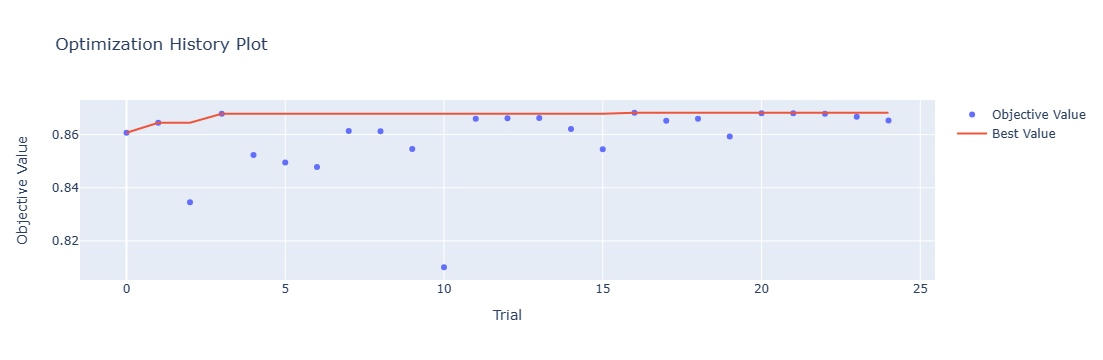

In [219]:
optuna.visualization.plot_optimization_history(study)

In [227]:
pred_val = []
pred_score_val = []

cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_main_, y_train_main_)):
    X_train_, X_val_ = X_train_main_.iloc[train_idx], X_train_main_.iloc[val_idx]
    y_train_, y_val_ = y_train_main_[train_idx], y_train_main_[val_idx]

    model2 = LGBMClassifier(**study.best_params, is_unbalance=True, random_state=RAND, metric='AUC')
    model2.fit(X_train_, y_train_, verbose=0)

    y_pred_val = model2.predict(X_val_)
    y_score_val = model2.predict_proba(X_val_)

    print("Fold:", fold + 1, "ROC-AUC SCORE %.3f" % roc_auc_score(y_val_, y_score_val[:, 1]))
    print("---")

    pred_val.append(y_pred_val)
    pred_score_val.append(y_score_val)

# обучаем модель для предсказания на test
model2.fit(X_train_main_, y_train_main_)

meta_X['lgb_tuned'] = np.concatenate(pred_score_val)[:,1]
meta_X_test['lgb_tuned'] = model2.predict_proba(X_val_main)[:,1]

Fold: 1 ROC-AUC SCORE 0.864
---
Fold: 2 ROC-AUC SCORE 0.861
---
Fold: 3 ROC-AUC SCORE 0.860
---
Fold: 4 ROC-AUC SCORE 0.846
---
Fold: 5 ROC-AUC SCORE 0.862
---


In [233]:
metrics_val = pd.concat([metrics_val, get_metrics_classification(y_val_main, model2.predict(X_val_main), model2.predict_proba(X_val_main), name='LGBM Tuned')])
metrics_val

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,LGBM Baseline,0.805372,0.866423,0.401429,0.776243,0.529190,0.428424
0,LGBM Tuned,0.853640,0.868227,0.486056,0.674033,0.564815,0.388048


In [234]:
metrics_test = pd.concat([metrics_test, get_metrics_classification(y_test_main, model2.predict(X_test_main), model2.predict_proba(X_test_main), name='LGBM Tuned')])
metrics_test

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,LGBM Baseline,0.872875,0.799159,0.738255,0.150892,0.250569,0.385490
0,LGBM Tuned,0.880410,0.847495,0.772277,0.213992,0.335124,0.315372


In [235]:
check_overfitting(model=model2, X_train=X_train_main, X_test=X_test_main, y_train=y_train_main, y_test=y_test_main, metric_fun=roc_auc_score)

roc_auc_score train: 0.858
roc_auc_score test: 0.847
delta = 1.2 %


# XGB Tuned

In [224]:
def objective_xgb(trial, random_state):
    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 900),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        # 'num_leaves': trial.suggest_int('num_leaves', 10, 1000),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
    }

    model = XGBClassifier(**xgb_params, random_state=RAND, objective='binary:logistic')
    model.fit(X_train_main_, y_train_main_, eval_metric='auc', eval_set=[(X_val_main, y_val_main)], verbose=False)

    preds = model.predict_proba(X_val_main)[:, 1]
    score = roc_auc_score(y_val_main, preds)
    return score

study_xgb = optuna.create_study(direction="maximize")
pointer = lambda trial: objective_xgb(trial, random_state=RAND)
study_xgb.optimize(pointer, n_trials=35, show_progress_bar=True)

[I 2024-03-21 14:35:11,996] A new study created in memory with name: no-name-d4f16cef-374a-4495-ade3-954399a6bccd


  0%|          | 0/35 [00:00<?, ?it/s]

[I 2024-03-21 14:35:13,383] Trial 0 finished with value: 0.866133497885933 and parameters: {'n_estimators': 639, 'learning_rate': 0.011429375549302493, 'max_depth': 4, 'subsample': 0.7961440734104481, 'colsample_bytree': 0.9958456008249756}. Best is trial 0 with value: 0.866133497885933.
[I 2024-03-21 14:35:14,833] Trial 1 finished with value: 0.8395637186551079 and parameters: {'n_estimators': 534, 'learning_rate': 0.24788164055029374, 'max_depth': 5, 'subsample': 0.7338227257882679, 'colsample_bytree': 0.7091373861362809}. Best is trial 0 with value: 0.866133497885933.
[I 2024-03-21 14:35:16,817] Trial 2 finished with value: 0.8332590677077206 and parameters: {'n_estimators': 484, 'learning_rate': 0.1193418776646386, 'max_depth': 9, 'subsample': 0.940640636503159, 'colsample_bytree': 0.63920269148991}. Best is trial 0 with value: 0.866133497885933.
[I 2024-03-21 14:35:19,491] Trial 3 finished with value: 0.8186996673066862 and parameters: {'n_estimators': 722, 'learning_rate': 0.1653

In [225]:
study_xgb.best_params

{'n_estimators': 745,
 'learning_rate': 0.02093004760601575,
 'max_depth': 4,
 'subsample': 0.815587804415079,
 'colsample_bytree': 0.9334191677923097}

Saved:
{'n_estimators': 745,
 'learning_rate': 0.02093004760601575,
 'max_depth': 4,
 'subsample': 0.815587804415079,
 'colsample_bytree': 0.9334191677923097}

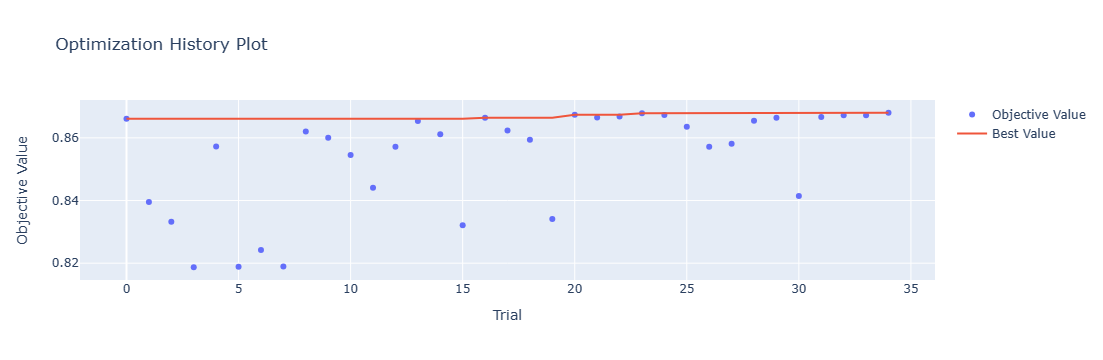

In [226]:
optuna.visualization.plot_optimization_history(study_xgb)

In [236]:
pred_val = []
pred_score_val = []

cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_main_, y_train_main_)):
    X_train_, X_val_ = X_train_main_.iloc[train_idx], X_train_main_.iloc[val_idx]
    y_train_, y_val_ = y_train_main_[train_idx], y_train_main_[val_idx]

    model3 = XGBClassifier(**study_xgb.best_params, random_state=RAND, objective='binary:logistic')
    model3.fit(X_train_, y_train_, eval_metric='auc', eval_set=[(X_val_main, y_val_main)], verbose=0)

    y_pred_val = model3.predict(X_val_)
    y_score_val = model3.predict_proba(X_val_)

    print("Fold:", fold + 1, "ROC-AUC SCORE %.3f" % roc_auc_score(y_val_, y_score_val[:, 1]))
    print("---")

    pred_val.append(y_pred_val)
    pred_score_val.append(y_score_val)

# обучаем модель для предсказания на test
model3.fit(X_train_main_, y_train_main_)

meta_X['xgb_tuned'] = np.concatenate(pred_score_val)[:,1]
meta_X_test['xgb_tuned'] = model3.predict_proba(X_val_main)[:,1]

Fold: 1 ROC-AUC SCORE 0.873
---
Fold: 2 ROC-AUC SCORE 0.865
---
Fold: 3 ROC-AUC SCORE 0.856
---
Fold: 4 ROC-AUC SCORE 0.851
---
Fold: 5 ROC-AUC SCORE 0.865
---


In [240]:
metrics_val = pd.concat([metrics_val, get_metrics_classification(y_val_main, model3.predict(X_val_main), model3.predict_proba(X_val_main), name='XGB Tuned')])
metrics_val

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,LGBM Baseline,0.805372,0.866423,0.401429,0.776243,0.529190,0.428424
0,LGBM Tuned,0.853640,0.868227,0.486056,0.674033,0.564815,0.388048
0,XGB Tuned,0.886726,0.868015,0.682051,0.367403,0.477558,0.279407


In [241]:
metrics_test = pd.concat([metrics_test, get_metrics_classification(y_test_main, model3.predict(X_test_main), model3.predict_proba(X_test_main), name='XGB Tuned')])
metrics_test

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,LGBM Baseline,0.872875,0.799159,0.738255,0.150892,0.250569,0.385490
0,LGBM Tuned,0.880410,0.847495,0.772277,0.213992,0.335124,0.315372
0,XGB Tuned,0.861476,0.848149,0.875000,0.019204,0.037584,0.479110


In [242]:
check_overfitting(model=model3, X_train=X_train_main, X_test=X_test_main, y_train=y_train_main, y_test=y_test_main, metric_fun=roc_auc_score)

roc_auc_score train: 0.852
roc_auc_score test: 0.848
delta = 0.4 %


# Catboost Baseline

In [243]:
pred_val = []
pred_score_val = []

cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_main_, y_train_main_)):
    X_train_, X_val_ = X_train_main_.iloc[train_idx], X_train_main_.iloc[val_idx]
    y_train_, y_val_ = y_train_main_[train_idx], y_train_main_[val_idx]

    model4 = CatBoostClassifier(random_state=RAND, auto_class_weights='Balanced', verbose=False)
    model4.fit(X_train_,
              y_train_,
              verbose=False)

    y_pred_val = model4.predict(X_val_)
    y_score_val = model4.predict_proba(X_val_)

    print("Fold:", fold + 1, "ROC-AUC SCORE %.3f" % roc_auc_score(y_val_, y_score_val[:, 1]))
    print("---")

    # holdout list
    pred_val.append(y_pred_val)
    pred_score_val.append(y_score_val)

# обучаем модель для предсказания на test
model4.fit(X_train_main_, y_train_main_)

meta_X['cb_base'] = np.concatenate(pred_score_val)[:,1]
meta_X_test['cb_base'] = model4.predict_proba(X_val_main)[:,1]

Fold: 1 ROC-AUC SCORE 0.859
---
Fold: 2 ROC-AUC SCORE 0.853
---
Fold: 3 ROC-AUC SCORE 0.847
---
Fold: 4 ROC-AUC SCORE 0.849
---
Fold: 5 ROC-AUC SCORE 0.853
---


In [244]:
metrics_val = pd.concat([metrics_val, get_metrics_classification(y_val_main, model4.predict(X_val_main), model4.predict_proba(X_val_main), name='Catboost Baseline')])
metrics_val

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,LGBM Baseline,0.805372,0.866423,0.401429,0.776243,0.529190,0.428424
0,LGBM Tuned,0.853640,0.868227,0.486056,0.674033,0.564815,0.388048
0,XGB Tuned,0.886726,0.868015,0.682051,0.367403,0.477558,0.279407
0,Catboost Baseline,0.809264,0.860902,0.405882,0.762431,0.529750,0.421407


In [245]:
metrics_test = pd.concat([metrics_test, get_metrics_classification(y_test_main, model4.predict(X_test_main), model4.predict_proba(X_test_main), name='Catboost Baseline')])
metrics_test

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,LGBM Baseline,0.872875,0.799159,0.738255,0.150892,0.250569,0.385490
0,LGBM Tuned,0.880410,0.847495,0.772277,0.213992,0.335124,0.315372
0,XGB Tuned,0.861476,0.848149,0.875000,0.019204,0.037584,0.479110
0,Catboost Baseline,0.872295,0.838464,0.854167,0.112483,0.198788,0.377549


In [246]:
check_overfitting(model=model4, X_train=X_train_main, X_test=X_test_main, y_train=y_train_main, y_test=y_test_main, metric_fun=roc_auc_score)

roc_auc_score train: 0.847
roc_auc_score test: 0.838
delta = 1.0 %


# Random Forest Tuned

In [248]:
def objective_rf(trial, random_state):
    rf_params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 900),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        'bootstrap': trial.suggest_categorical("bootstrap", [True]),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'max_samples': trial.suggest_float('max_samples', 0.3, 0.99),
        'max_features': trial.suggest_categorical("max_features", ['sqrt', 'log2']),
        'n_jobs': trial.suggest_categorical("n_jobs", [-1])
    }

    model = RandomForestClassifier(**rf_params, random_state=RAND, class_weight='balanced')
    model.fit(X_train_main_, y_train_main_)

    preds = model.predict_proba(X_val_main)[:, 1]
    score = roc_auc_score(y_val_main, preds)
    return score

study_rf = optuna.create_study(direction="maximize")
pointer = lambda trial: objective_rf(trial, random_state=RAND)
study_rf.optimize(pointer, n_trials=25, show_progress_bar=True)

[I 2024-03-21 14:50:25,365] A new study created in memory with name: no-name-2d14318c-f068-4a0c-a616-4253beac2ad7


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2024-03-21 14:50:25,901] Trial 0 finished with value: 0.8608627245805035 and parameters: {'n_estimators': 175, 'max_depth': 9, 'bootstrap': True, 'min_samples_leaf': 9, 'min_samples_split': 12, 'max_samples': 0.5020025220019371, 'max_features': 'sqrt', 'n_jobs': -1}. Best is trial 0 with value: 0.8608627245805035.
[I 2024-03-21 14:50:28,614] Trial 1 finished with value: 0.8644931871719065 and parameters: {'n_estimators': 853, 'max_depth': 15, 'bootstrap': True, 'min_samples_leaf': 4, 'min_samples_split': 7, 'max_samples': 0.6632651959670838, 'max_features': 'sqrt', 'n_jobs': -1}. Best is trial 1 with value: 0.8644931871719065.
[I 2024-03-21 14:50:29,868] Trial 2 finished with value: 0.8645319888751763 and parameters: {'n_estimators': 409, 'max_depth': 12, 'bootstrap': True, 'min_samples_leaf': 1, 'min_samples_split': 13, 'max_samples': 0.6017886306316345, 'max_features': 'log2', 'n_jobs': -1}. Best is trial 2 with value: 0.8645319888751763.
[I 2024-03-21 14:50:32,427] Trial 3 finish

In [249]:
study_rf.best_params

{'n_estimators': 730,
 'max_depth': 13,
 'bootstrap': True,
 'min_samples_leaf': 7,
 'min_samples_split': 14,
 'max_samples': 0.8053623789842076,
 'max_features': 'sqrt',
 'n_jobs': -1}

Saved:
{'n_estimators': 730,
 'max_depth': 13,
 'bootstrap': True,
 'min_samples_leaf': 7,
 'min_samples_split': 14,
 'max_samples': 0.8053623789842076,
 'max_features': 'sqrt',
 'n_jobs': -1}

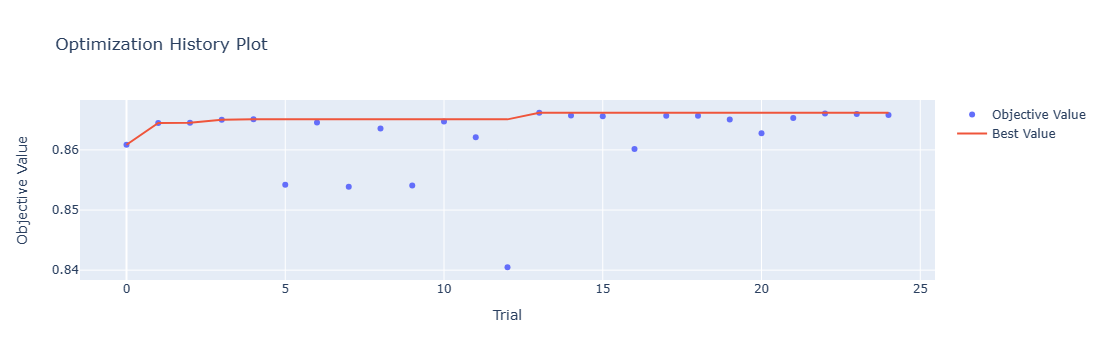

In [250]:
optuna.visualization.plot_optimization_history(study_rf)

In [251]:
pred_val = []
pred_score_val = []

cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_main_, y_train_main_)):
    X_train_, X_val_ = X_train_main_.iloc[train_idx], X_train_main_.iloc[val_idx]
    y_train_, y_val_ = y_train_main_[train_idx], y_train_main_[val_idx]

    model5 = RandomForestClassifier(**study_rf.best_params, random_state=RAND, class_weight='balanced')
    model5.fit(X_train_, y_train_)

    y_pred_val = model5.predict(X_val_)
    y_score_val = model5.predict_proba(X_val_)

    print("Fold:", fold + 1, "ROC-AUC SCORE %.3f" % roc_auc_score(y_val_, y_score_val[:, 1]))
    print("---")

    pred_val.append(y_pred_val)
    pred_score_val.append(y_score_val)

# обучаем модель для предсказания на test
model5.fit(X_train_main_, y_train_main_)

meta_X['xgb_tuned'] = np.concatenate(pred_score_val)[:,1]
meta_X_test['xgb_tuned'] = model5.predict_proba(X_val_main)[:,1]

Fold: 1 ROC-AUC SCORE 0.865
---
Fold: 2 ROC-AUC SCORE 0.860
---
Fold: 3 ROC-AUC SCORE 0.860
---
Fold: 4 ROC-AUC SCORE 0.848
---
Fold: 5 ROC-AUC SCORE 0.864
---


In [252]:
metrics_val = pd.concat([metrics_val, get_metrics_classification(y_val_main, model5.predict(X_val_main), model5.predict_proba(X_val_main), name='Rand For Tuned')])
metrics_val

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,LGBM Baseline,0.805372,0.866423,0.401429,0.776243,0.529190,0.428424
0,LGBM Tuned,0.853640,0.868227,0.486056,0.674033,0.564815,0.388048
0,XGB Tuned,0.886726,0.868015,0.682051,0.367403,0.477558,0.279407
0,Catboost Baseline,0.809264,0.860902,0.405882,0.762431,0.529750,0.421407
0,Rand For Tuned,0.808486,0.866185,0.404692,0.762431,0.528736,0.426545


In [253]:
metrics_test = pd.concat([metrics_test, get_metrics_classification(y_test_main, model5.predict(X_test_main), model5.predict_proba(X_test_main), name='Rand For Tuned')])
metrics_test

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,LGBM Baseline,0.872875,0.799159,0.738255,0.150892,0.250569,0.385490
0,LGBM Tuned,0.880410,0.847495,0.772277,0.213992,0.335124,0.315372
0,XGB Tuned,0.861476,0.848149,0.875000,0.019204,0.037584,0.479110
0,Catboost Baseline,0.872295,0.838464,0.854167,0.112483,0.198788,0.377549
0,Rand For Tuned,0.883114,0.855856,0.632479,0.406036,0.494570,0.332283


In [254]:
check_overfitting(model=model5, X_train=X_train_main, X_test=X_test_main, y_train=y_train_main, y_test=y_test_main, metric_fun=roc_auc_score)

roc_auc_score train: 0.863
roc_auc_score test: 0.856
delta = 0.8 %


# Logistic Regression

In [255]:
pred_val = []
pred_score_val = []

cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_main_, y_train_main_)):
    X_train_, X_val_ = X_train_main_.iloc[train_idx], X_train_main_.iloc[val_idx]
    y_train_, y_val_ = y_train_main_[train_idx], y_train_main_[val_idx]

    model6 = LogisticRegression(class_weight='balanced', random_state=RAND)
    model6.fit(X_train_, y_train_)

    y_pred_val = model6.predict(X_val_)
    y_score_val = model6.predict_proba(X_val_)

    print("Fold:", fold + 1, "ROC-AUC SCORE %.3f" % roc_auc_score(y_val_, y_score_val[:, 1]))
    print("---")

    # holdout list
    pred_val.append(y_pred_val)
    pred_score_val.append(y_score_val)

# обучаем модель для предсказания на test
model6.fit(X_train_main_, y_train_main_)

meta_X['cb_base'] = np.concatenate(pred_score_val)[:,1]
meta_X_test['cb_base'] = model6.predict_proba(X_val_main)[:,1]

Fold: 1 ROC-AUC SCORE 0.855
---
Fold: 2 ROC-AUC SCORE 0.856
---
Fold: 3 ROC-AUC SCORE 0.843
---
Fold: 4 ROC-AUC SCORE 0.833
---
Fold: 5 ROC-AUC SCORE 0.853
---


In [256]:
metrics_val = pd.concat([metrics_val, get_metrics_classification(y_val_main, model6.predict(X_val_main), model6.predict_proba(X_val_main), name='Log Reg Baseline')])
metrics_val

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,LGBM Baseline,0.805372,0.866423,0.401429,0.776243,0.529190,0.428424
0,LGBM Tuned,0.853640,0.868227,0.486056,0.674033,0.564815,0.388048
0,XGB Tuned,0.886726,0.868015,0.682051,0.367403,0.477558,0.279407
0,Catboost Baseline,0.809264,0.860902,0.405882,0.762431,0.529750,0.421407
0,Rand For Tuned,0.808486,0.866185,0.404692,0.762431,0.528736,0.426545
0,Log Reg Baseline,0.778902,0.848448,0.361559,0.743094,0.486438,0.484596


In [257]:
metrics_test = pd.concat([metrics_test, get_metrics_classification(y_test_main, model6.predict(X_test_main), model6.predict_proba(X_test_main), name='Log Reg Baseline')])
metrics_test

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,LGBM Baseline,0.872875,0.799159,0.738255,0.150892,0.250569,0.385490
0,LGBM Tuned,0.880410,0.847495,0.772277,0.213992,0.335124,0.315372
0,XGB Tuned,0.861476,0.848149,0.875000,0.019204,0.037584,0.479110
0,Catboost Baseline,0.872295,0.838464,0.854167,0.112483,0.198788,0.377549
0,Rand For Tuned,0.883114,0.855856,0.632479,0.406036,0.494570,0.332283
0,Log Reg Baseline,0.626352,0.847655,0.257740,0.879287,0.398632,0.662171


In [258]:
check_overfitting(model=model6, X_train=X_train_main, X_test=X_test_main, y_train=y_train_main, y_test=y_test_main, metric_fun=roc_auc_score)

roc_auc_score train: 0.847
roc_auc_score test: 0.848
delta = 0.1 %


# Voting

In [262]:
clb_lg1 = CalibratedClassifierCV(base_estimator=model1, method='isotonic', cv=3)
clb_lg2 = CalibratedClassifierCV(base_estimator=model2, method='isotonic', cv=3)
clb_xg1 = CalibratedClassifierCV(base_estimator=model3, method='isotonic', cv=3)
clb_cb1 = CalibratedClassifierCV(base_estimator=model4, method='isotonic', cv=3)
clb_rf1 = CalibratedClassifierCV(base_estimator=model5, method='isotonic', cv=3)
clb_lr1 = CalibratedClassifierCV(base_estimator=model6, method='isotonic', cv=3)

In [297]:
vt_clf = VotingClassifier(estimators=[('lg1', clb_lg1), ('lg2', clb_lg2), ('xg1', clb_xg1), ('cb1', clb_cb1), ('rf1', clb_rf1), ('lr1', clb_lr1)], voting='soft')
vt_clf.fit(X_train_main_, y_train_main_)

VotingClassifier(estimators=[('lg1',
                              CalibratedClassifierCV(base_estimator=LGBMClassifier(is_unbalance=True,
                                                                                   random_state=10),
                                                     cv=3, method='isotonic')),
                             ('lg2',
                              CalibratedClassifierCV(base_estimator=LGBMClassifier(colsample_bytree=0.5010681356698323,
                                                                                   is_unbalance=True,
                                                                                   learning_rate=0.0027213754476726384,
                                                                                   max_depth=9,
                                                                                   metric='AUC',
                                                                                   n_estimators=575,
                                                                                   num_leave...
                              CalibratedClassifierCV(base_estimator=RandomForestClassifier(class_weight='balanced',
                                                                                           max_depth=13,
                                                                                           max_samples=0.8053623789842076,
                                                                                           min_samples_leaf=7,
                                                                                           min_samples_split=14,
                                                                                           n_estimators=730,
                                                                                           n_jobs=-1,
                                                                                           random_state=10),
                                                     cv=3, method='isotonic')),
                             ('lr1',
                              CalibratedClassifierCV(base_estimator=LogisticRegression(class_weight='balanced',
                                                                                       random_state=10),
                                                     cv=3,
                                                     method='isotonic'))],
                 voting='soft')

In [298]:
y_predicted = vt_clf.predict(X_test_main)
y_score = vt_clf.predict_proba(X_test_main)

In [299]:
metrics = get_metrics_classification(y_test_main, y_predicted, y_score, name='VotingClassifier2_soft')
metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,VotingClassifier2_soft,0.864181,0.851926,0.933333,0.038409,0.073781,0.330917


In [300]:
check_overfitting(model=vt_clf, X_train=X_train_main_, X_test=X_test_main, y_train=y_train_main_, y_test=y_test_main, metric_fun=roc_auc_score)

roc_auc_score train: 0.907
roc_auc_score test: 0.852
delta = 6.4 %


# Combining

нужно переобучать для правильного meta_X_test

In [268]:
# st_clf = KNeighborsClassifier()
# st_clf.fit(meta_X, y_train_main_)

KNeighborsClassifier()

In [269]:
# st_clf.predict(meta_X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [161]:
# metrics = pd.concat([metrics, get_metrics_classification(y_test_main, st_clf.predict(meta_X_test), st_clf.predict_proba(meta_X_test), name='Meta KNN')])
# metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,LGBM Baseline,0.800638,0.862970,0.389952,0.738671,0.510438,0.428073
0,LGBM Tuned,0.790861,0.865632,0.378765,0.759819,0.505528,0.438761
0,XGB Tuned,0.889692,0.867243,0.699164,0.379154,0.491675,0.278191
0,Catboost Baseline,0.809352,0.862692,0.401509,0.723565,0.516442,0.413952
0,Rand Forest Tuned,0.830818,0.866874,0.438078,0.716012,0.543578,0.398924
0,Log Reg,0.792986,0.853735,0.381098,0.755287,0.506586,0.474962
0,VotingClassifier_soft,0.887991,0.867172,0.718447,0.335347,0.457261,0.279168
0,Meta KNN,0.844208,0.516457,0.191304,0.033233,0.056628,2.550210


In [162]:
# st_clf = LogisticRegression(random_state=RAND, class_weight='balanced')
# st_clf.fit(meta_X, y_train_main)

LogisticRegression(class_weight='balanced', random_state=10)

In [163]:
# st_clf.predict(meta_X_test)

array([1, 0, 0, ..., 1, 0, 1])

In [164]:
# metrics = pd.concat([metrics, get_metrics_classification(y_test_main, st_clf.predict(meta_X_test), st_clf.predict_proba(meta_X_test), name='Meta Log Reg')])
# metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,LGBM Baseline,0.800638,0.862970,0.389952,0.738671,0.510438,0.428073
0,LGBM Tuned,0.790861,0.865632,0.378765,0.759819,0.505528,0.438761
0,XGB Tuned,0.889692,0.867243,0.699164,0.379154,0.491675,0.278191
0,Catboost Baseline,0.809352,0.862692,0.401509,0.723565,0.516442,0.413952
0,Rand Forest Tuned,0.830818,0.866874,0.438078,0.716012,0.543578,0.398924
0,Log Reg,0.792986,0.853735,0.381098,0.755287,0.506586,0.474962
0,VotingClassifier_soft,0.887991,0.867172,0.718447,0.335347,0.457261,0.279168
0,Meta KNN,0.844208,0.516457,0.191304,0.033233,0.056628,2.550210
0,Meta Log Reg,0.416578,0.305151,0.074029,0.273414,0.116511,0.693900


# Stacking

In [277]:
estimators = list()
estimators.append(('LGBM Baseline', LGBMClassifier(random_state=RAND, is_unbalance=True)))
estimators.append(('LGBM Tuned', LGBMClassifier(**study.best_params, is_unbalance=True, random_state=RAND, metric='AUC')))
estimators.append(('XGB Tuned', XGBClassifier(**study_xgb.best_params, random_state=RAND, objective='binary:logistic')))
estimators.append(('Catboost Baseline', CatBoostClassifier(random_state=RAND, auto_class_weights='Balanced', verbose=False)))
estimators.append(('Random Forest Tuned', RandomForestClassifier(**study_rf.best_params, random_state=RAND, class_weight='balanced')))
estimators.append(('Logistic Regression', LogisticRegression(class_weight='balanced', random_state=RAND)))
# meta_model = KNeighborsClassifier() # Stacking_sklearn
meta_model = LogisticRegression(class_weight='balanced', random_state=RAND) # Stacking_sklearn2

In [301]:
SC = StackingClassifier(estimators=estimators, final_estimator=meta_model, cv=5)
SC.fit(X_train_main_, y_train_main_)
y_pred = SC.predict(X_test_main)
y_score = SC.predict_proba(X_test_main)

In [302]:
metrics = pd.concat([metrics, get_metrics_classification(y_test_main, y_pred, y_score, name='Stacking_sklearn2')])
metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,VotingClassifier2_soft,0.864181,0.851926,0.933333,0.038409,0.073781,0.330917
0,Stacking_sklearn2,0.880796,0.854871,0.598246,0.467764,0.525019,0.341665


In [303]:
check_overfitting(model=SC, X_train=X_train_main_, X_test=X_test_main, y_train=y_train_main_, y_test=y_test_main, metric_fun=roc_auc_score)

roc_auc_score train: 0.900
roc_auc_score test: 0.855
delta = 5.2 %


# Blending

In [284]:
from sklearn.base import BaseEstimator, ClassifierMixin


class BlendingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, models, ens_model):
        """
        models - базовые модели для стекинга
        ens_model - мета-модель
        """
        self.models = models
        self.ens_model = ens_model

    def fit(self,
            X: pd.DataFrame,
            y: pd.Series,
            test_size: float = 0.15,
            random_state: int = 10):
        """
        Обучение ансамбля моделей
        """
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, stratify=y, test_size=test_size, random_state=random_state)

        # список с новыми признаками на validation
        meta_X = list()

        for model in self.models:
            # обучение на train датасете
            model.fit(X_train, y_train)
            # ответы на validation выборке
            yhat = model.predict(X_val)
            # преобразование в столбец
            yhat = yhat.reshape(len(yhat), 1)
            # запись в новый датасет
            meta_X.append(yhat)

        meta_X = np.hstack(meta_X)
        # обучение мета-алгоритма
        self.ens_model.fit(meta_X, y_val)
        return self

    def predict(self, X: pd.DataFrame) -> np.array:
        """
        получение прогнозов - классов
        """
        meta_X = list()
        
        for model in self.models:
            # ответы на test выборке
            yhat = model.predict(X)      
            yhat = yhat.reshape(len(yhat), 1)
            meta_X.append(yhat)
        meta_X = np.hstack(meta_X)
        return self.ens_model.predict(meta_X)

    def predict_proba(self, X: pd.DataFrame) -> np.array:
        """
        получение прогнозов - вероятностей
        """
        meta_X = list()
        
        for model in self.models:
            # ответы на test выборке
            yhat = model.predict(X)
            yhat = yhat.reshape(len(yhat), 1)
            meta_X.append(yhat)
        meta_X = np.hstack(meta_X)
        
        return self.ens_model.predict_proba(meta_X)

In [285]:
clb_lg1 = CalibratedClassifierCV(base_estimator=model1, method='isotonic', cv=3)
clb_lg2 = CalibratedClassifierCV(base_estimator=model2, method='isotonic', cv=3)
clb_xg1 = CalibratedClassifierCV(base_estimator=model3, method='isotonic', cv=3)
clb_cb1 = CalibratedClassifierCV(base_estimator=model4, method='isotonic', cv=3)
clb_rf1 = CalibratedClassifierCV(base_estimator=model5, method='isotonic', cv=3)
clb_lr1 = CalibratedClassifierCV(base_estimator=model6, method='isotonic', cv=3)
models = [clb_lg1, clb_lg2, clb_xg1, clb_cb1, clb_rf1, clb_lr1]
meta_model = LogisticRegression(class_weight='balanced', random_state=RAND)
# meta_model = KNN

In [292]:
blended = BlendingClassifier(models, meta_model)
blended.fit(X=X_train_main_, y=y_train_main_, random_state=RAND)

BlendingClassifier(ens_model=LogisticRegression(class_weight='balanced',
                                                random_state=10),
                   models=[CalibratedClassifierCV(base_estimator=LGBMClassifier(is_unbalance=True,
                                                                                random_state=10),
                                                  cv=3, method='isotonic'),
                           CalibratedClassifierCV(base_estimator=LGBMClassifier(colsample_bytree=0.5010681356698323,
                                                                                is_unbalance=True,
                                                                                learning_rate=0.002721375447672638...
                           CalibratedClassifierCV(base_estimator=RandomForestClassifier(class_weight='balanced',
                                                                                        max_depth=13,
                                                                                        max_samples=0.8053623789842076,
                                                                                        min_samples_leaf=7,
                                                                                        min_samples_split=14,
                                                                                        n_estimators=730,
                                                                                        n_jobs=-1,
                                                                                        random_state=10),
                                                  cv=3, method='isotonic'),
                           CalibratedClassifierCV(base_estimator=LogisticRegression(class_weight='balanced',
                                                                                    random_state=10),
                                                  cv=3, method='isotonic')])

In [293]:
y_predicted = blended.predict(X_test_main)
y_score = blended.predict_proba(X_test_main)

In [294]:
metrics = pd.concat([metrics, get_metrics_classification(y_test_main, y_predicted, y_score, name='Blending')])
metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,VotingClassifier2_soft,0.888910,0.868881,0.723837,0.341564,0.464119,0.278015
0,Stacking_sklearn1,0.870363,0.780259,0.564732,0.347051,0.429907,1.565811
0,Stacking_sklearn1,0.863988,0.728480,0.735849,0.053498,0.099744,2.063903
0,Stacking_sklearn2,0.797334,0.868534,0.389959,0.777778,0.519469,0.458494
0,Stacking_sklearn2,0.880796,0.854871,0.598246,0.467764,0.525019,0.341665
0,Blending,0.863988,0.730214,0.516426,0.539095,0.527517,0.559061
0,Blending,0.887172,0.688200,0.667436,0.396433,0.497418,0.563449
0,Blending,0.863988,0.730214,0.516426,0.539095,0.527517,0.559061


In [296]:
check_overfitting(model=blended, X_train=X_train_main_, X_test=X_test_main, y_train=y_train_main_, y_test=y_test_main, metric_fun=roc_auc_score)

roc_auc_score train: 0.703
roc_auc_score test: 0.730
delta = 3.7 %


# Test submission

In [310]:
test = pd.read_csv('../data/kaggle/affrica_fin_incl/Test.csv')
checker = test.copy()
checker.drop(columns='uniqueid', inplace=True)
checker = pd.get_dummies(checker)
checker[numeric_columns] = sc.transform(checker[numeric_columns])

In [315]:
test['bank_account'] = model6.predict(checker)
submission = pd.DataFrame({"uniqueid": test["uniqueid"] + " x " + test["country"],
                           "bank_account": test.bank_account})
submission.to_csv('6_sumb.csv', index = False)

In [312]:
metrics_test

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,LGBM Baseline,0.872875,0.799159,0.738255,0.150892,0.250569,0.385490
0,LGBM Tuned,0.880410,0.847495,0.772277,0.213992,0.335124,0.315372
0,XGB Tuned,0.861476,0.848149,0.875000,0.019204,0.037584,0.479110
0,Catboost Baseline,0.872295,0.838464,0.854167,0.112483,0.198788,0.377549
0,Rand For Tuned,0.883114,0.855856,0.632479,0.406036,0.494570,0.332283
0,Log Reg Baseline,0.626352,0.847655,0.257740,0.879287,0.398632,0.662171
